In [31]:
import os
import json
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

# for my transformations
#import librosa
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, ClippingDistortion, Gain, SevenBandParametricEQ


def resize_mel_spectrogram(mel_spec, desired_shape=(224, 224)):
    # Convert the 2D Mel spectrogram to 4D tensor (batch, channels, height, width)
    mel_spec_tensor = torch.tensor(mel_spec).unsqueeze(0).unsqueeze(0)
    # Resize
    resized_mel_spec = F.interpolate(mel_spec_tensor, size=desired_shape, mode='bilinear', align_corners=False)
    return resized_mel_spec.squeeze(0).squeeze(0).numpy()

# augmentation
augment_raw_audio = Compose(
    [
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.0005, p=1), # good
        PitchShift(min_semitones=-2, max_semitones=12, p=0.5), #set values so it doesnt shift too low, rmeoving bomb signal
        TimeStretch(p = 0.5), # defaults are fine
        ClippingDistortion(0, 5, p = 0.5), # tested params to make sure its good
        Gain(-10, 5, p = 0.5), # defaults are fine
        #SevenBandParametricEQ(-12, 12, p = 0.5)
    ]
)

# Modify the load_audio_and_get_mel_spectrogram function:
def load_audio_and_get_mel_spectrogram(filename, sr=8000, n_mels=128, n_fft=1024, hop_length=64, win_length=512):
    y, _ = librosa.load(filename, sr=sr)
    augmented_signal = augment_raw_audio(y, sr)

    mel_spectrogram = librosa.feature.melspectrogram(y=augmented_signal, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mel_spectrogram_resized = resize_mel_spectrogram(mel_spectrogram)
    return mel_spectrogram_resized



class CTDataset(Dataset):

    def __init__(self, cfg, split, transform):
        '''
            Constructor. Here, we collect and index the dataset inputs and labels.
        '''
        #if split == 'unlabeled':
         #   print('This will not work unless you change the getitem function to have no labels for the unlabeled set') 
        self.data_root = cfg['data_path']
        self.split = split
        self.transform = transform
#

        # index data from JSON file
        self.data = []
        with open(cfg['json_path'], 'r') as f:
            json_data = json.load(f)
            for sublist in json_data.values():
                for entry in sublist:
                    #print(entry)

                    if entry["data_type"] == split:
                        path = entry["file_name"]
                        label = entry["class"]
                        self.data.append((path, label))

    def __len__(self):
        '''
            Returns the length of the dataset.
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
            Returns a single data point at given idx.
            Here's where we actually load the audio and get the Mel spectrogram.
        '''
        audio_path, label = self.data[idx]

        # load audio and get Mel spectrogram
        mel_spectrogram = load_audio_and_get_mel_spectrogram(os.path.join(self.data_root, audio_path))

        # make 3 dimensions, so shape goes from [x, y] to [3, x, y]
        mel_spectrogram_tensor = torch.tensor(mel_spectrogram).unsqueeze(0).repeat(3, 1, 1).float()
        
        # the old transform call, its now ditched
        #if self.transform:
         #   mel_spectrogram_tensor = self.transform(mel_spectrogram_tensor)

        # return the objects, label is commented out for now
        return mel_spectrogram_tensor#, label

In [32]:
# Sample config for demonstration
cfg_sample = {
    'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', 
    'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json'
}

# Let's see if the class is structured correctly:
audio_dataset = CTDataset(cfg_sample, 'train_data', None)

In [5]:
len(audio_dataset)

54457

In [9]:
audio_dataset[0].shape

torch.Size([3, 224, 224])

### Plot a raw audio files
First plot a melspec of a raw audio file. Next we will plot a melspec from the tensor from an audio_dataset object. They should look similar in quality (though the audio_dataset obj will be augmented).


In [14]:
import matplotlib.pyplot as plt

/home/ben/data/full_dataset/train_data.convmet.027795.palmyra_other.bioph_cascading_saw.wav


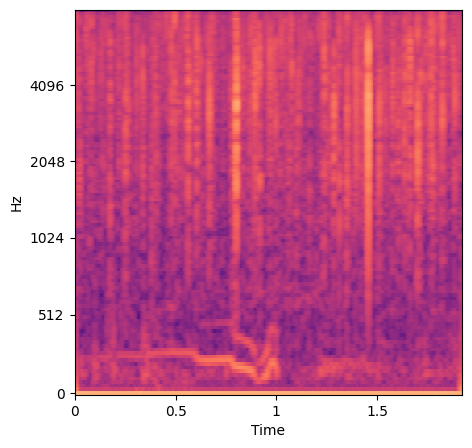

In [191]:
import os 

# pick a file from full_dataset
num = 5000
hop_length = 64
sample_rate = 16000

# find all train files in full_dataset
files = os.listdir(cfg_sample['data_root'])
train_files = [f for f in files if f.startswith('train_data')]

# get the files full path
audio_file_path = cfg_sample['data_root'] + train_files[num]
print(audio_file_path)
    
# load an audio file
audio, sample_rate = librosa.load(audio_file_path, sr = sample_rate)

# compute the mel spectrogram of the audio
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=64, win_length=1024)

# convert the power spectrogram to decibel (dB) units 
mel_spec_db = librosa.power_to_db(S=mel_spec, ref=1.0) 

#### plot the spectrogram
plt.figure(figsize=(5, 5))
librosa.display.specshow(mel_spec_db, sr=sample_rate,  
                        y_axis='mel', x_axis='time',  
                        vmin = -100, vmax = 0, 
                        cmap = 'magma', hop_length=hop_length)

Now the the mel_spectrogram_np tensor plot

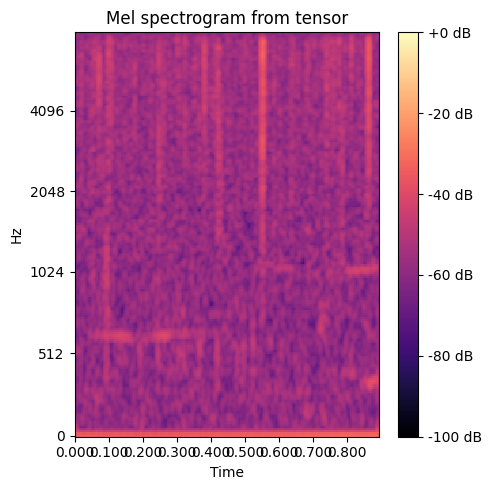

In [33]:
# Get the Mel spectrogram tensor for a dataset item (e.g., the first item)
mel_spectrogram_tensor = audio_dataset[10000]

# Convert the tensor back to numpy for visualization and apply dB scaling
mel_spectrogram_np = mel_spectrogram_tensor.numpy()[0]  # Selecting one channel for visualization
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram_np, ref=1.0)

# Plot the Mel spectrogram using the settings you provided
plt.figure(figsize=(5, 5))
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, 
                         n_fft=2048, hop_length=64, win_length=1024,
                         y_axis='mel', x_axis='time',
                         vmin=-100, vmax=0,
                         cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram from tensor')
plt.tight_layout()
plt.show()